* Test daily plume position in three months.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

In [3]:
octriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
mayriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_U.nc')
janriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_U.nc')

octnowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
maynowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_U.nc')
jannowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_U.nc')

octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

In [4]:
octriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')
mayriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_V.nc')
janriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_V.nc')

octnowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
maynowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_V.nc')
jannowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_V.nc')

octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc')

In [5]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [6]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted+1,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.nanmean(S[tst:ted+1,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [7]:
def threshold_whole_domain2(grid_T,tst,ted,dep_ind,dep):
    """Plot the boundary of the plume and threshold salinity"""
    
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    ## plot plume edge on 
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='cyan',linewidths=(1,))
    print(S_thre)
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.plot(lon[0,:],lat[0,:],'r-')
    ax.plot(lon[-1,:],lat[-1,:],'r-')
    ax.plot(lon[:,0],lat[:,0],'r-')
    ax.plot(lon[:,-1],lat[:,-1],'r-')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])

In [8]:
def area_plume(grid_T,tst,ted,dep_ind,dep,yslices,xslices):
    """Return the indices of plume region based on definition"""
    jss  = []; iss = []; 
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for j in np.arange(yslices):
        for i in np.arange(xslices):
            if W[j,i] - S_thre >= 0.:
                jss.append(j)
                iss.append(i)
    return jss, iss, S_thre,W

In [9]:
def test_boundary(jss,iss,grid_T):
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])  
    ax.plot(lon[0,:],lat[0,:],'r-')
    ax.plot(lon[-1,:],lat[-1,:],'r-')
    ax.plot(lon[:,0],lat[:,0],'r-')
    ax.plot(lon[:,-1],lat[:,-1],'r-')
    for j, i in zip(jss,iss):
        ax.plot(lon[j,i],lat[j,i],'*')
    return ax

In [10]:
def freshwater_xy(grid_T,tst,ted,dep_ind,xslices):
    """Calculate the freshwater over depths for all grid cells"""
    S0 = 30;
    S = grid_T.variables['vosaline'][tst:ted+1,:,:,:xslices]
    ssh = grid_T.variables['sossheig'][...,:xslices]
    fresh = np.zeros(S.shape)
    for t in np.arange(ted+1-tst):
        for z in np.arange(dep_ind):
            adj_ssh = 1+ssh[t+tst]/np.sum(e3t[...,:xslices]*tmask[...,:xslices],axis = 0)
            fresh[t,z] = (1-S[t,z]/S0)*e3t[z,:,:xslices]*adj_ssh[:]*tmask[z,:,:xslices] ## mask zero salinity here
    fresh_depth = np.nansum(fresh,axis = 1) ## integral over depths
    fresh_ave = np.nanmean(fresh_depth,axis=0) ## averaged over time of fresh water at each grid cell
    return fresh_ave

In [11]:
def plume_position1(grid_T,tst,ted,dep,fresh_ave,yslices,xslices):
    """Identify centered plume position defined by the formula shown in the first markdown"""
    i_po_nu = np.zeros(e1t.shape); j_po_nu = np.zeros(e1t.shape); ## j position numerator
    i_po_de = np.zeros(e1t.shape); j_po_de = np.zeros(e1t.shape);
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for jj in np.arange(yslices):
        for ii in np.arange(xslices):
            if W[jj,ii] - S_thre >= 0.:
                j_po_nu[jj,ii] = np.nan
                j_po_de[jj,ii] = np.nan
                i_po_nu[jj,ii] = np.nan
                i_po_de[jj,ii] = np.nan
            elif  W[jj,ii] - S_thre < 0:
                j_po_nu[jj,ii] = jj*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                j_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_nu[jj,ii] = ii*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]

    i_po = np.nansum(i_po_nu)/np.nansum(i_po_de)
    j_po = np.nansum(j_po_nu)/np.nansum(j_po_de)
    return j_po,i_po

In [13]:
def plot_plume_position(grid_T1,grid_T2,tst,ted,dep_ind,dep,yslices,xslices,strings):
    """Plot the plume position under with and without Coriolis force, or with or without moderate/strong wind,
    here by convention, grid_T1 should always be all_T.nc. Pcolormesh of last plot is the difference."""
    fresh_aves = {}; ipos = {};jpos = {}
    #jss,iss,S_thre,W = area_plume(grid_T1,tst,ted,dep_ind,dep,yslices,xslices) ## plume boundary same with f and no f
    fig,axs = plt.subplots(1,3,figsize = (20,9))
    for gridT, string, ax,c in zip([grid_T1,grid_T2],strings,[axs[0],axs[1]],['g','purple']):
        jss,iss,S_thre,W = area_plume(gridT,tst,ted,dep_ind,dep,yslices,xslices) ## plume boundary different
        fresh_aves[string] = freshwater_xy(gridT,tst,ted,dep_ind,xslices)
        jpos[string],ipos[string] = plume_position1(gridT,tst,ted,dep,fresh_aves[string],yslices,xslices)
    
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        
        fr_aveno0 = np.ma.masked_values(fresh_aves[string],0)
        CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = 0, vmax = 5,cmap = 'jet')
        cbar = fig.colorbar(CS,ax = ax,orientation='horizontal')
        cbar.set_label('Freshwater at each grid cell [m]')
        ax.plot(lon[jpos[string],ipos[string]],lat[jpos[string],ipos[string]],color =c,marker = '*',markersize = 10,label =string)
        ax.legend(loc = 'best')
        CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ## add salinity boundary
        plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
        ax.plot(lon[0:,xslices],lat[0:,xslices],'r-')
    ax = axs[2]
    fr_aveno0 = np.ma.masked_values(fresh_aves[strings[1]]-fresh_aves[strings[0]],0)
    CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = -2, vmax = 2,cmap = 'bwr')
    cbar = fig.colorbar(CS,ax = ax,orientation='horizontal')
    cbar.set_label('Difference of freshwater at each grid cell [m]')
    ax.plot(lon[jpos[strings[0]],ipos[strings[0]]],lat[jpos[strings[0]],ipos[strings[0]]],color = 'g',marker = '*',markersize = 10,label =strings[0])
    ax.plot(lon[jpos[strings[1]],ipos[strings[1]]],lat[jpos[strings[1]],ipos[strings[1]]],color = 'purple',marker = '*',markersize = 10,label =strings[1])
    ax.legend(loc = 'best')
    for ax in axs:    
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.6])
        ax.set_ylim([48.85,49.65])
    return jpos,ipos

# Test everyday in May to make sure the pattern of freshwater distribution is bi-directional

In [15]:
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77

{'all': 78.195683114077383, 'nowind': 71.88507590954147} {'all': 52.465340598159329, 'nowind': 56.867600956369259}
{'all': 65.892353266269936, 'nowind': 72.120889555718932} {'all': 45.302765038840867, 'nowind': 51.650009582500566}
{'all': 54.911746544991274, 'nowind': 70.9823176389216} {'all': 41.863395923649946, 'nowind': 61.754413106482424}
{'all': 58.388231366761119, 'nowind': 70.856177941089683} {'all': 46.244124571186298, 'nowind': 55.22690576366557}
{'all': 73.188995710163255, 'nowind': 79.093707595380195} {'all': 58.674499368518823, 'nowind': 63.630994668172157}
{'all': 81.387362215042884, 'nowind': 83.774146929496993} {'all': 55.689066258011337, 'nowind': 66.144435642033898}
{'all': 81.855453430774304, 'nowind': 81.646553576180082} {'all': 49.969207915784132, 'nowind': 60.989559909490879}
{'all': 75.690513501685913, 'nowind': 73.23211394467468} {'all': 46.116907676074753, 'nowind': 48.558102751385242}
{'all': 71.663406832422581, 'nowind': 71.741614726741858} {'all': 48.28508350

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 63.405630672504927, 'nowind': 83.068473176885107} {'all': 41.570314407549546, 'nowind': 42.976384790419452}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 64.339980182921053, 'nowind': 87.613814844862958} {'all': 41.718915618018222, 'nowind': 46.56159419663512}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 66.808592306602918, 'nowind': 86.703908516760109} {'all': 45.192564322050409, 'nowind': 45.624542227961989}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 77.407648646505507, 'nowind': 84.289172396405391} {'all': 51.544957361433035, 'nowind': 42.090959784881541}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 83.676605242693725, 'nowind': 77.893942274490101} {'all': 52.842741318212205, 'nowind': 39.023755715043912}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 81.545895751183934, 'nowind': 74.329464842938691} {'all': 48.582638912923322, 'nowind': 39.03927572909442}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 79.576507128875974, 'nowind': 72.998222948485903} {'all': 45.733250751020265, 'nowind': 39.324677576044401}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 81.579860491474207, 'nowind': 71.55223065851456} {'all': 44.690629523832925, 'nowind': 39.640687376466779}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 74.024010936082419, 'nowind': 70.156237578239669} {'all': 42.353885838796877, 'nowind': 40.012706683545332}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 62.661826118350312, 'nowind': 69.437461736584709} {'all': 43.874534941586049, 'nowind': 40.278242004242209}


/ocean/jieliu/Anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'all': 63.437240131357889, 'nowind': 68.955334652236601} {'all': 48.562668645937549, 'nowind': 40.577926810941285}


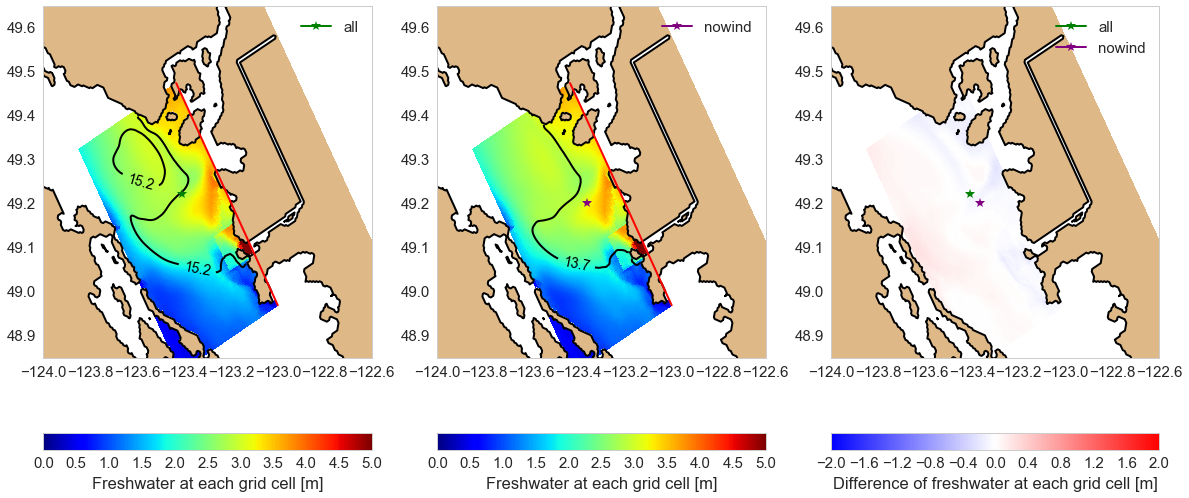

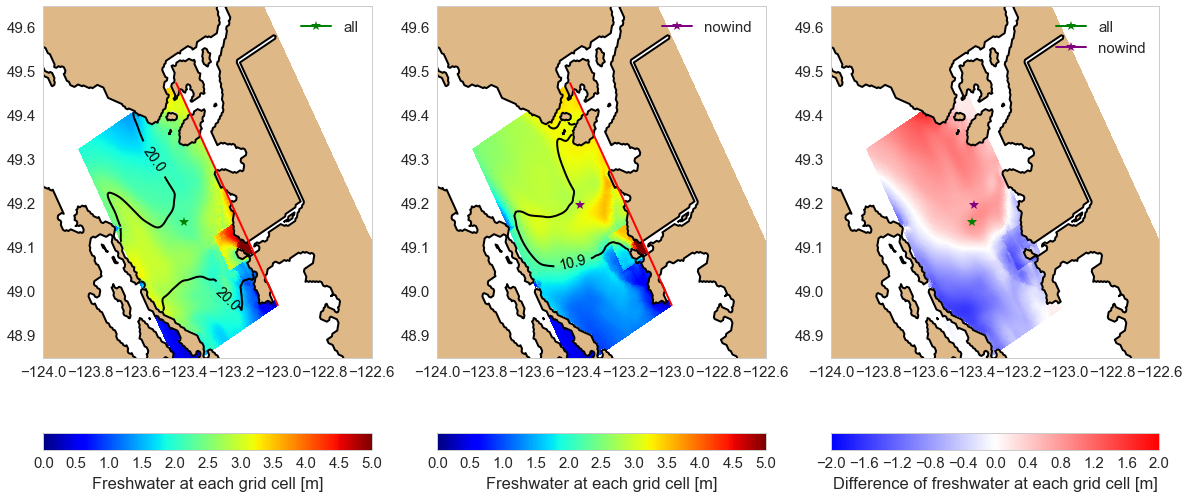

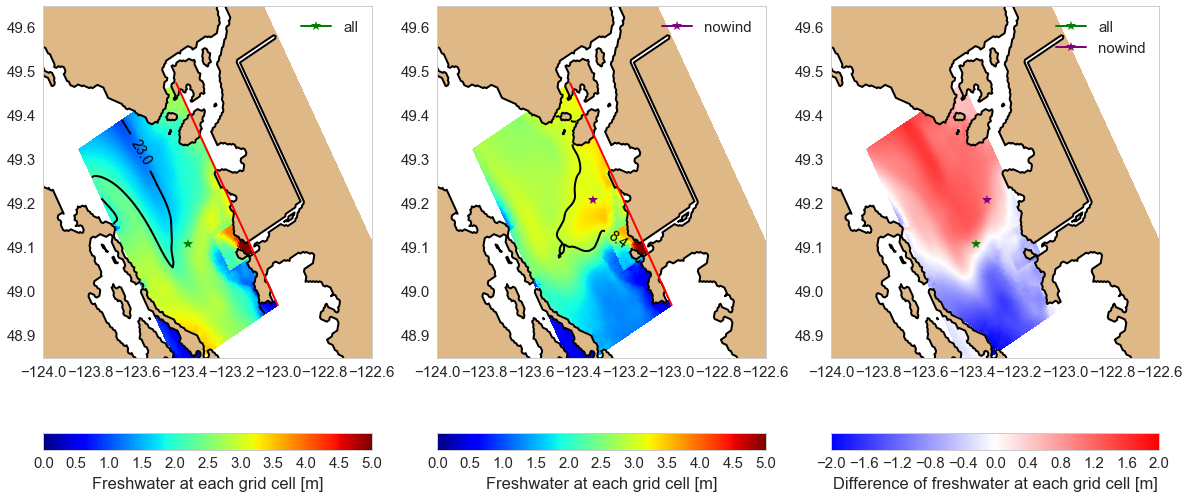

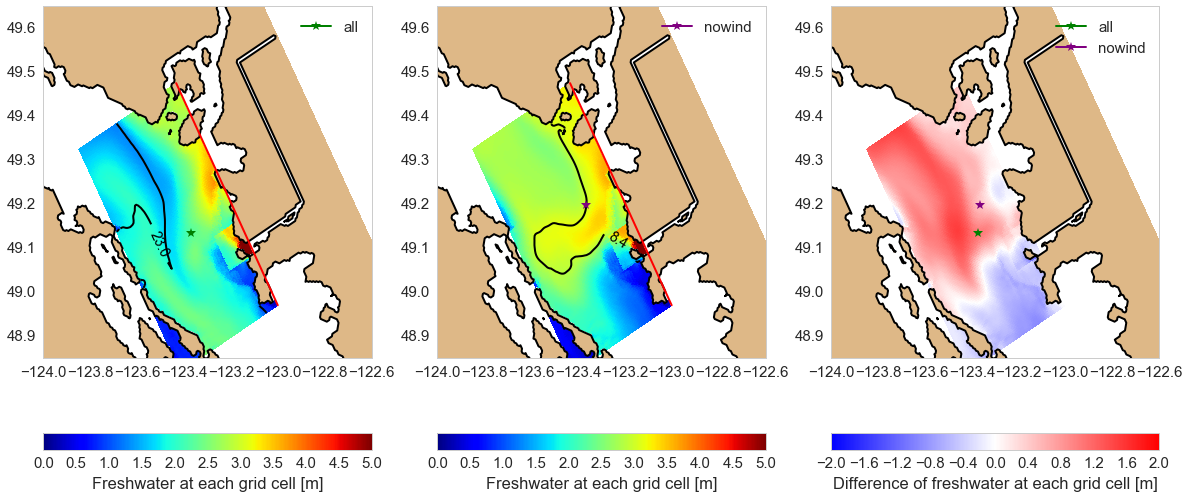

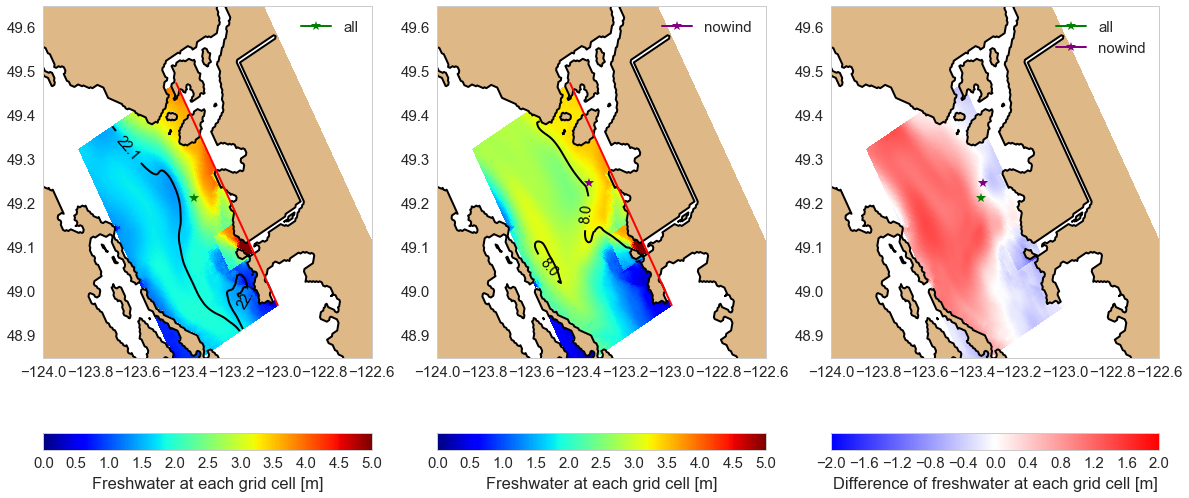

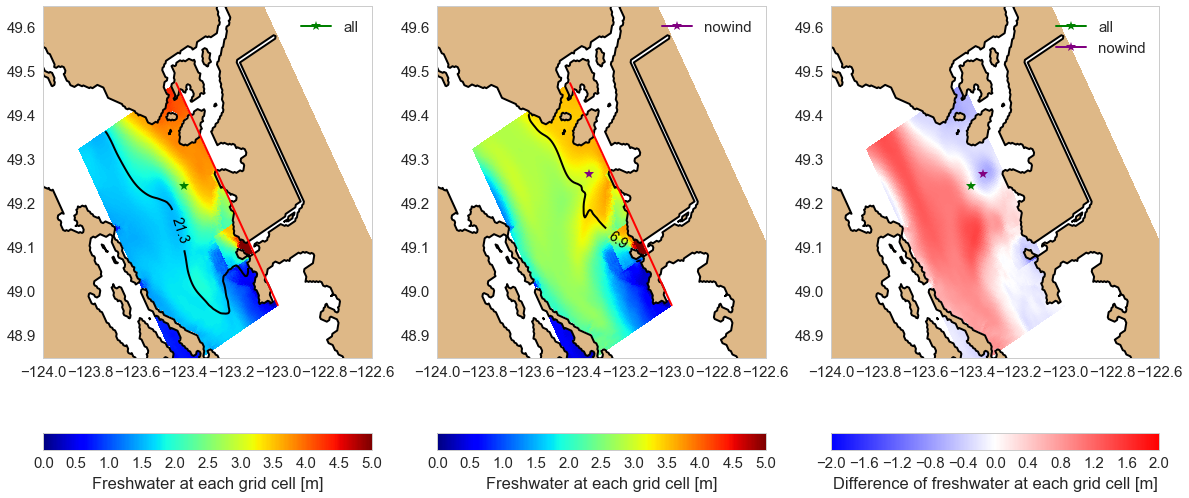

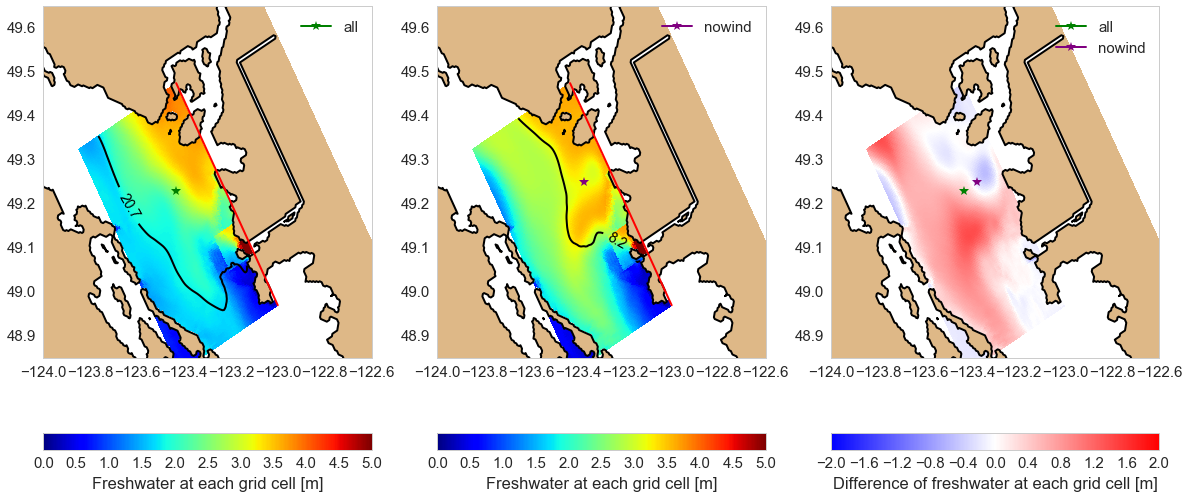

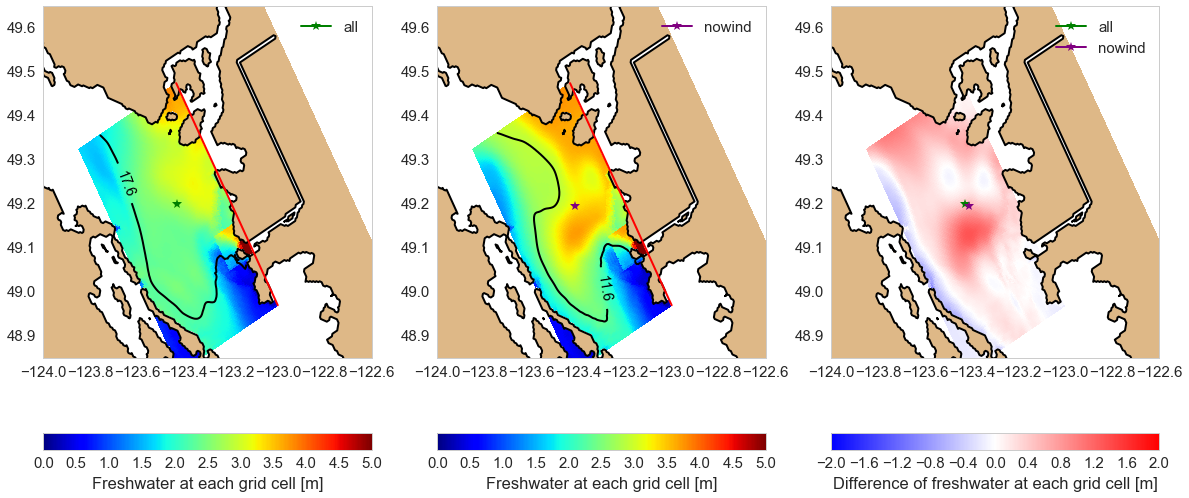

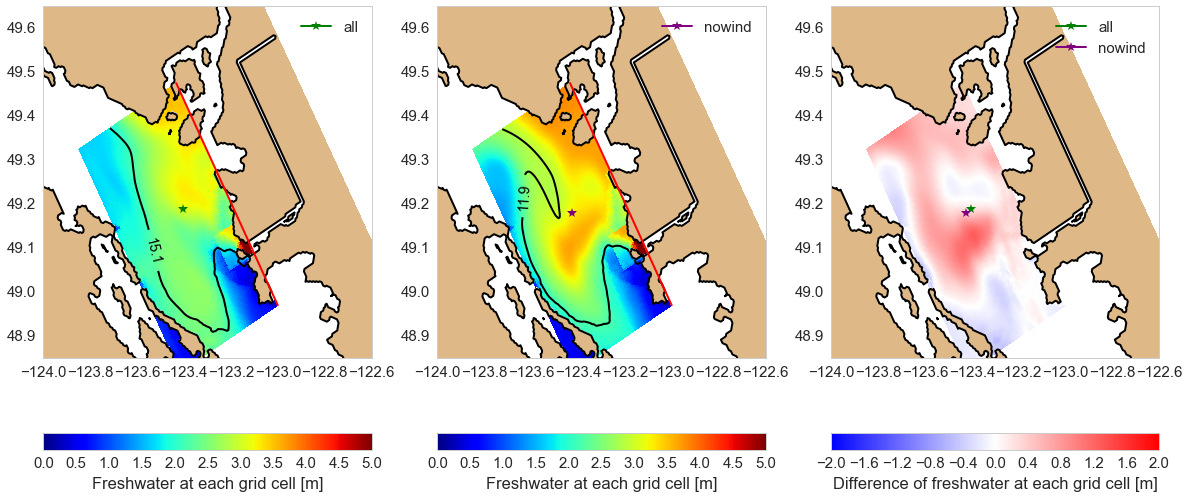

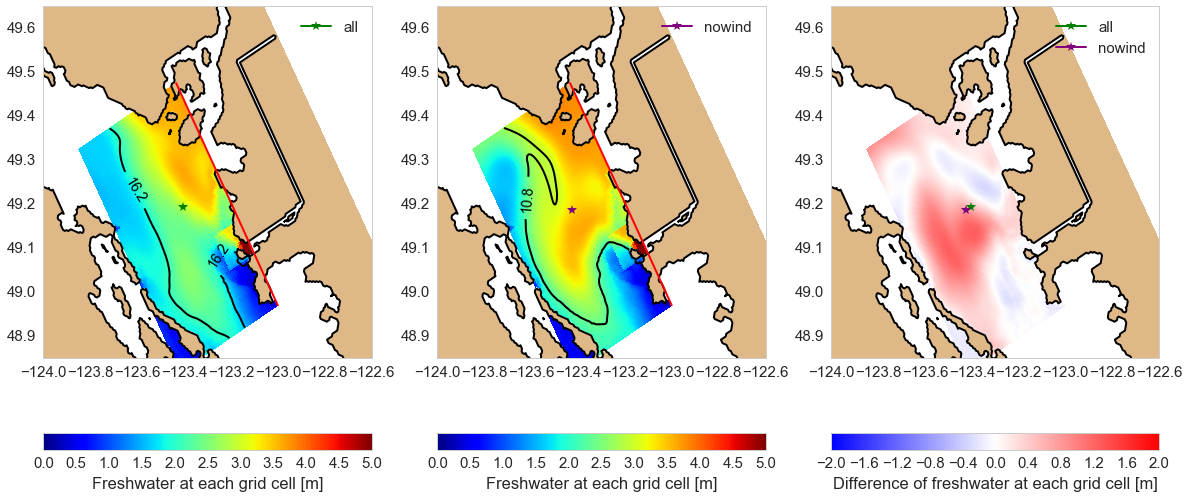

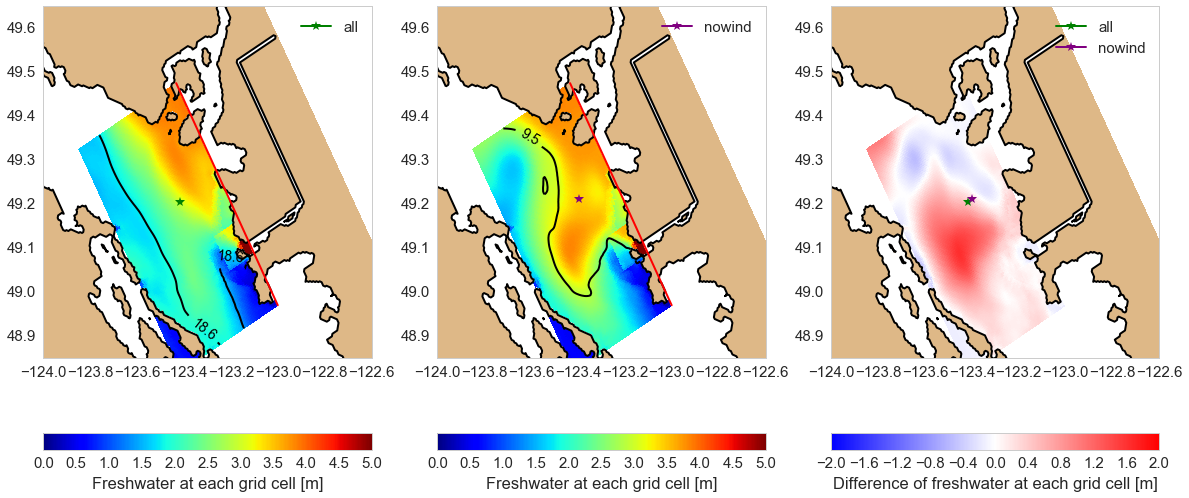

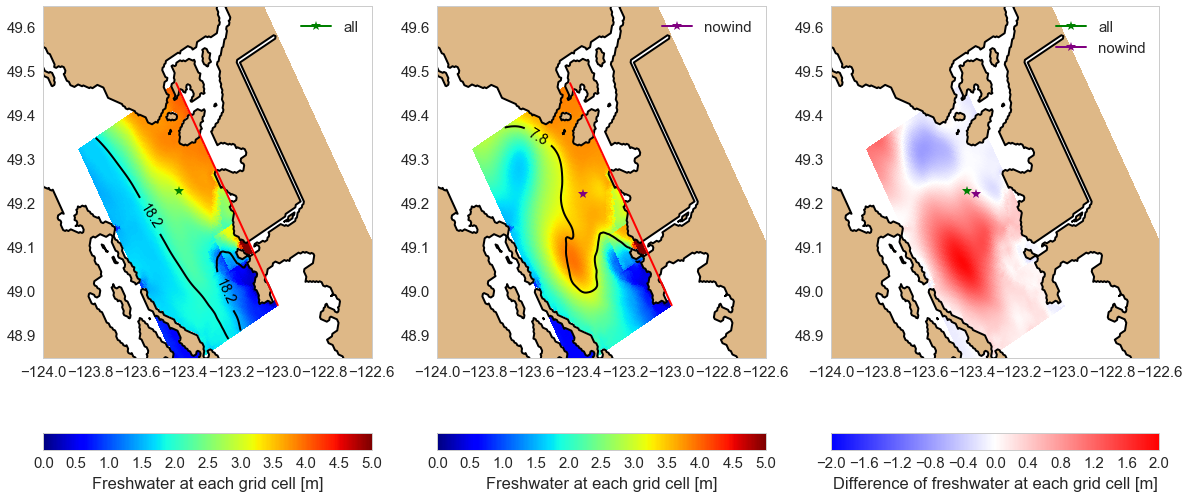

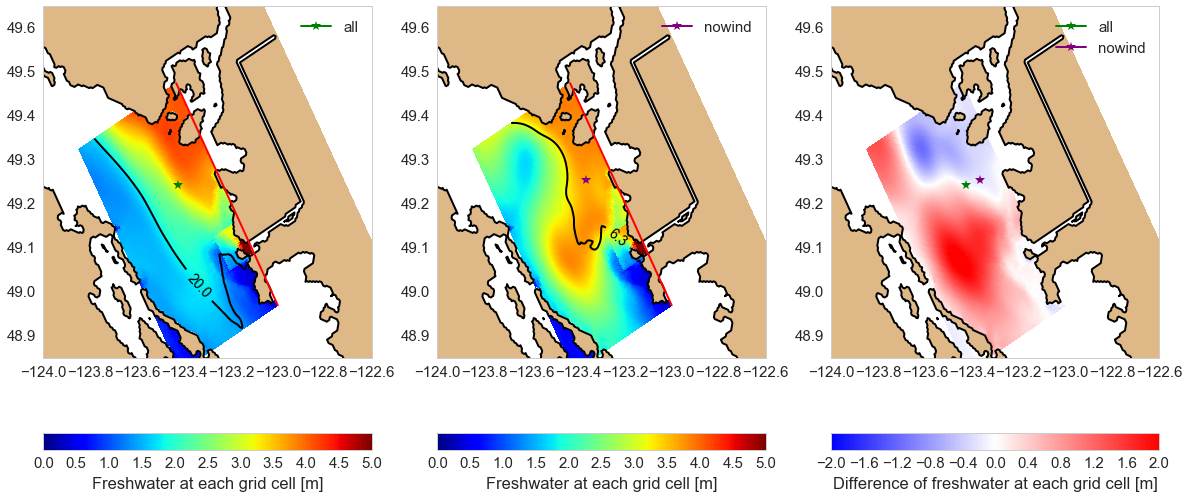

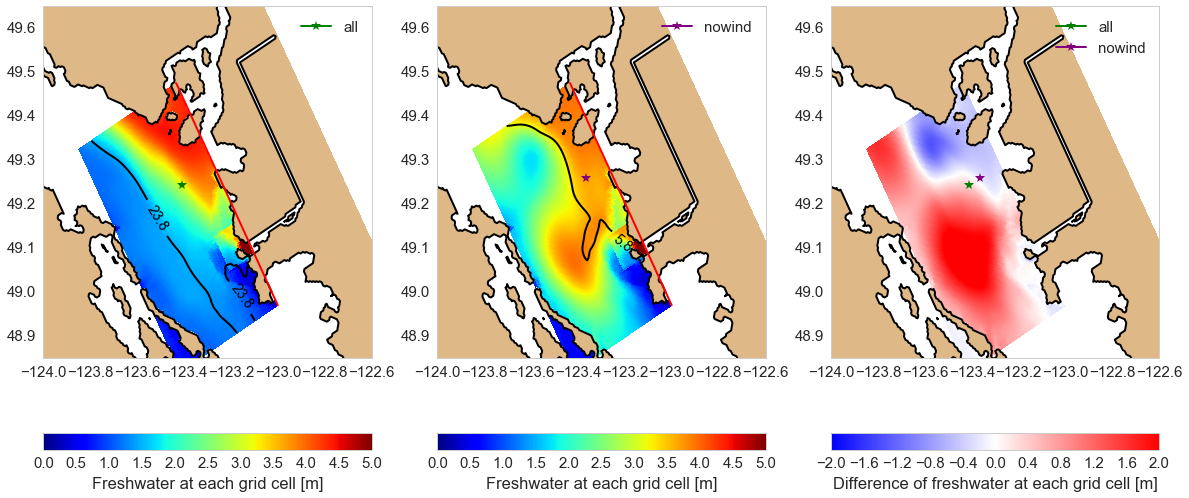

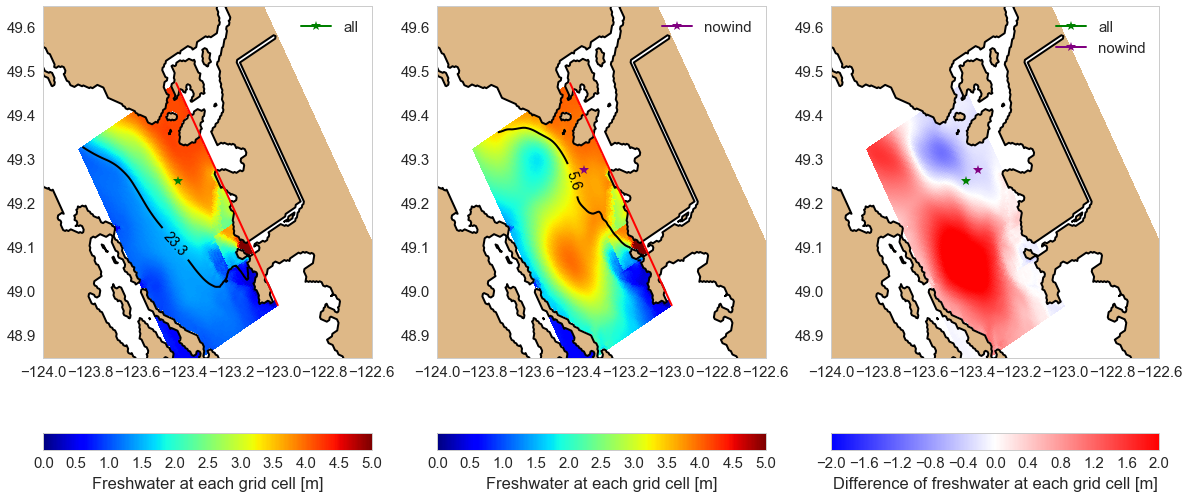

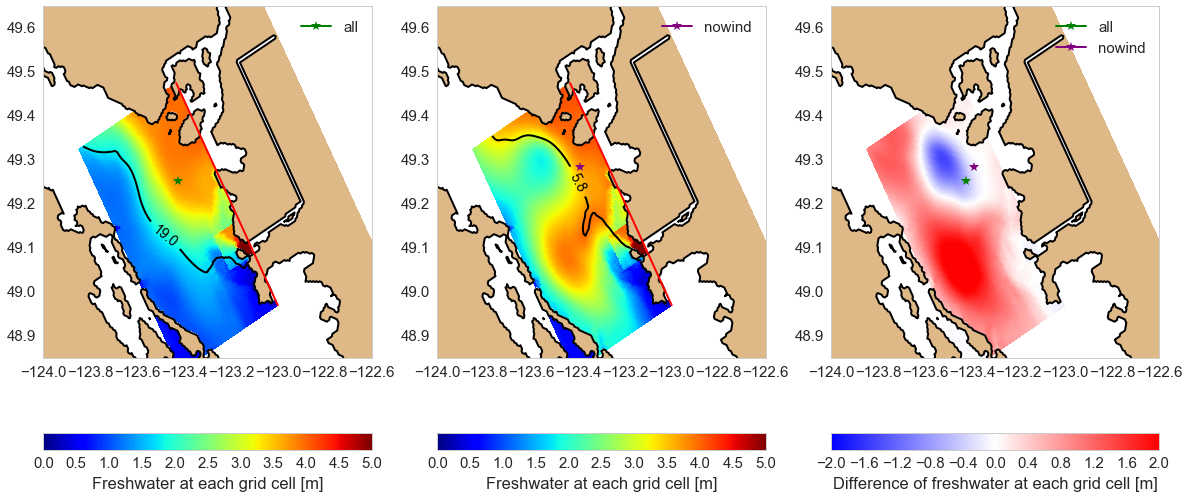

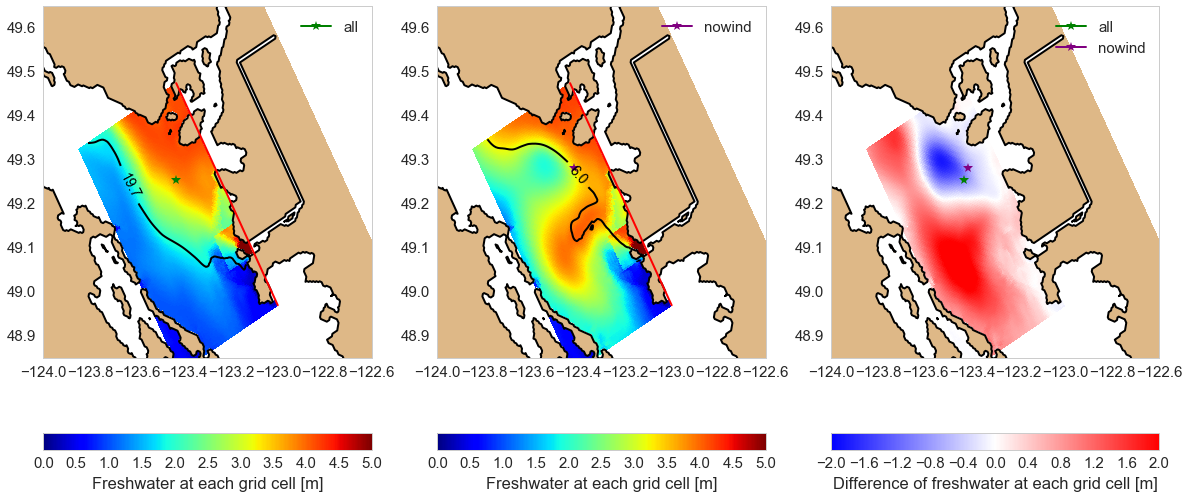

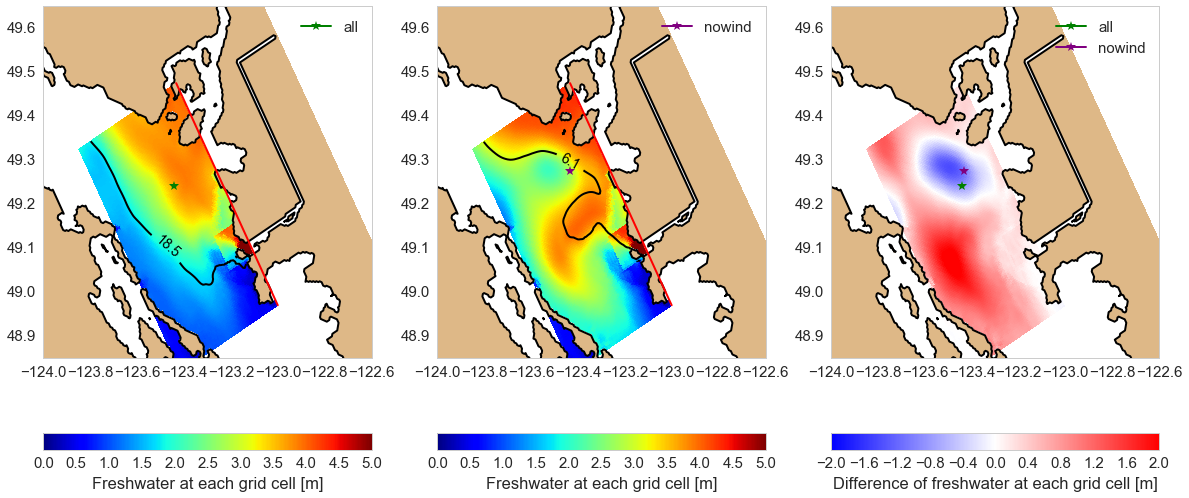

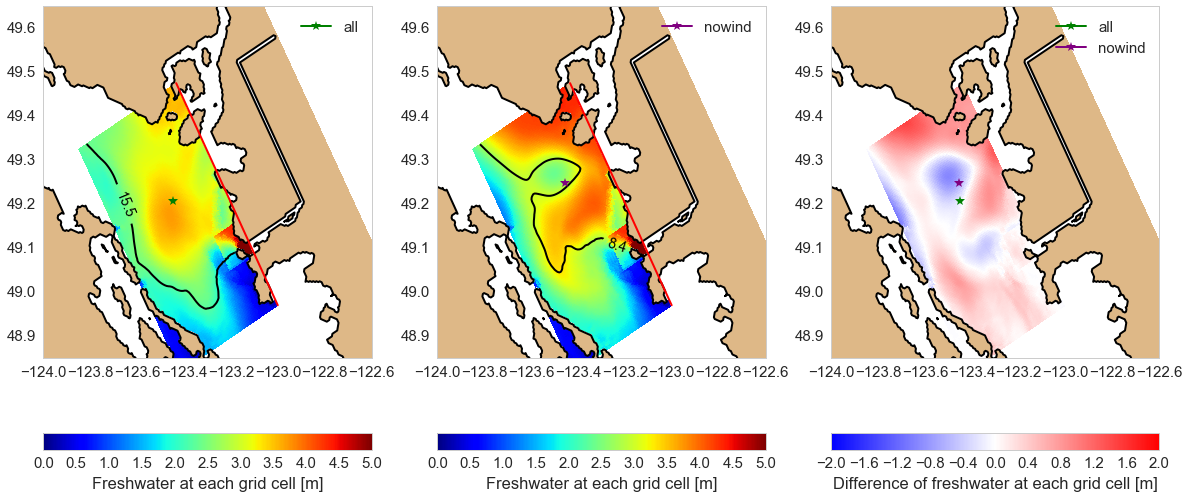

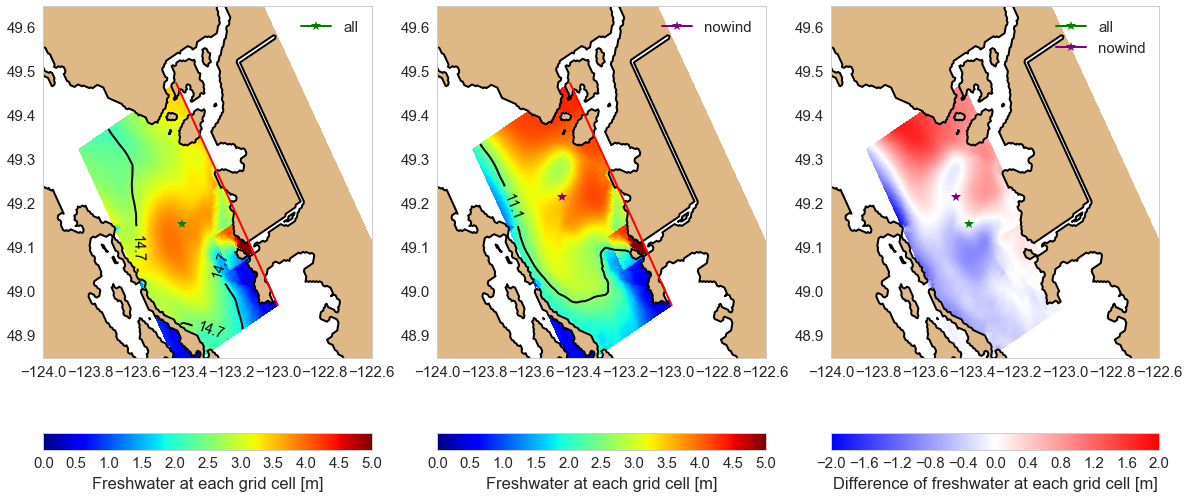

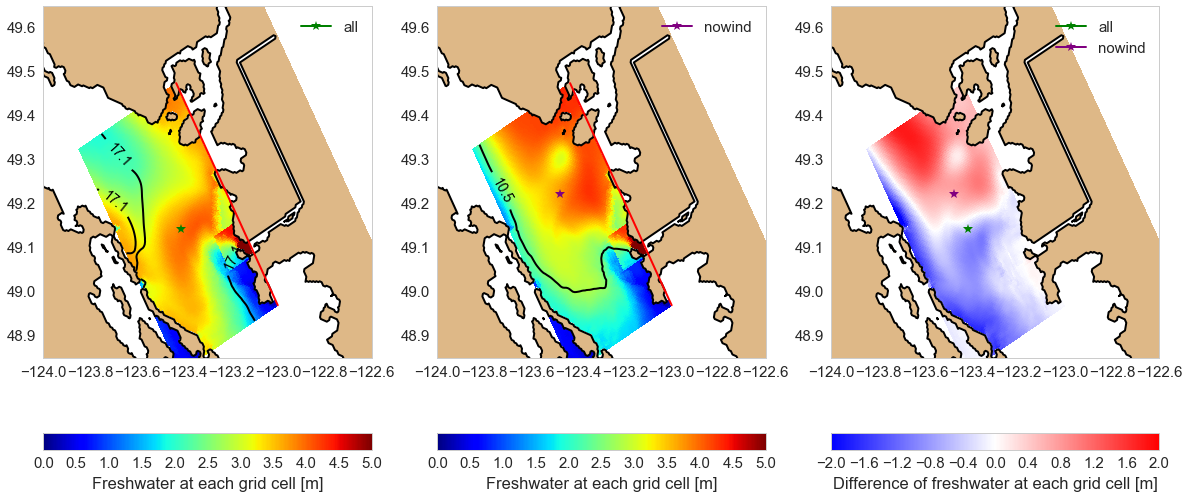

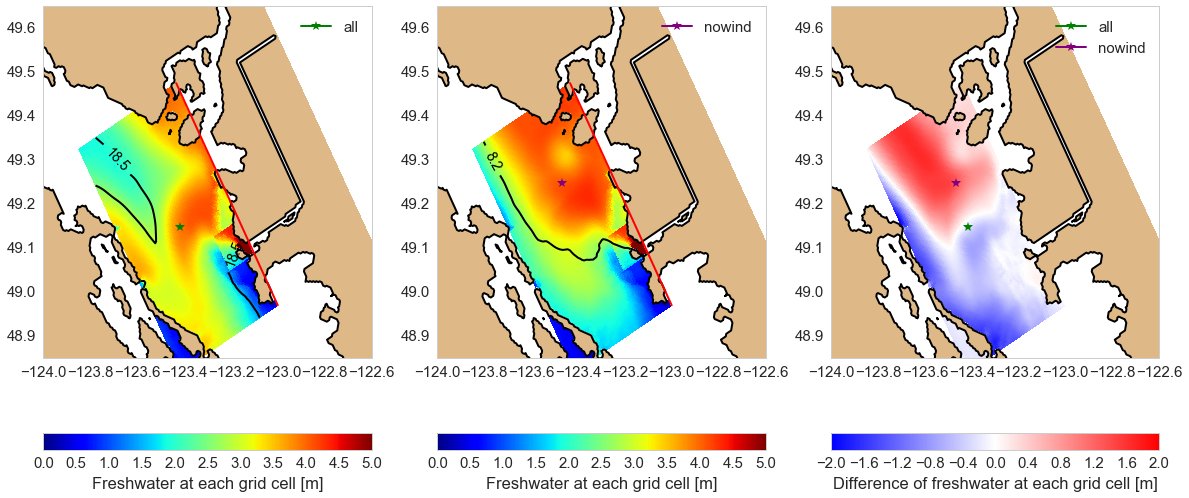

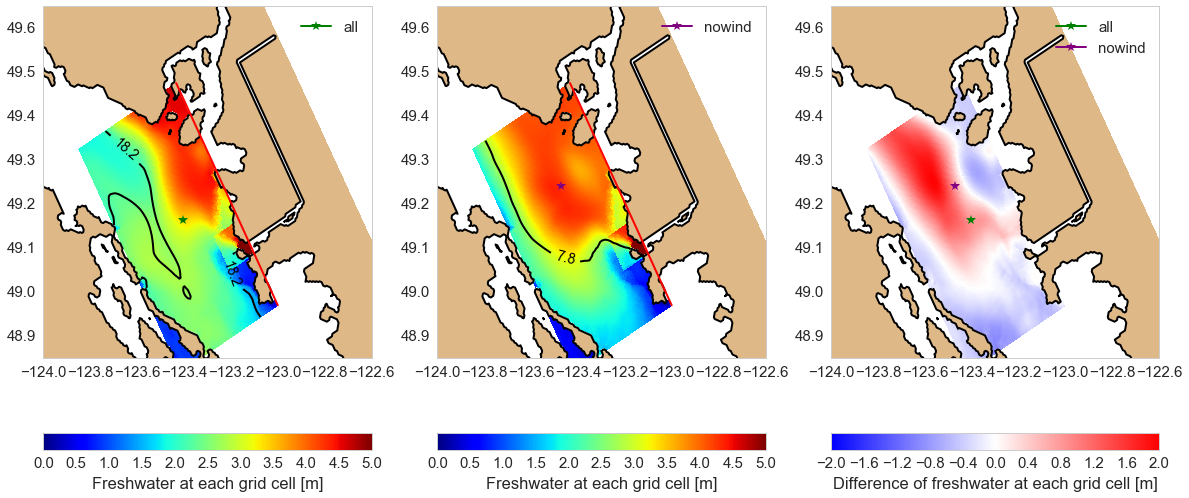

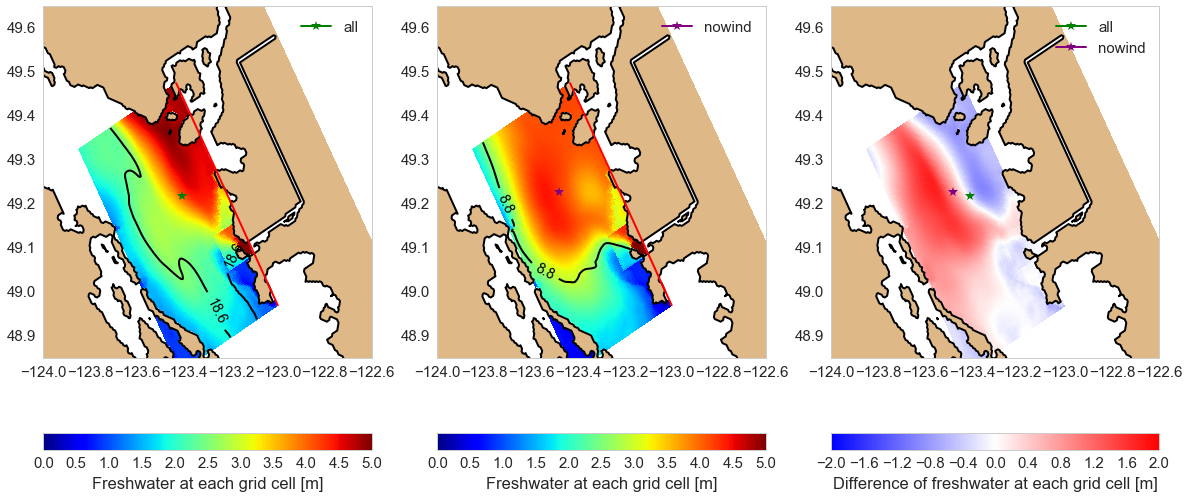

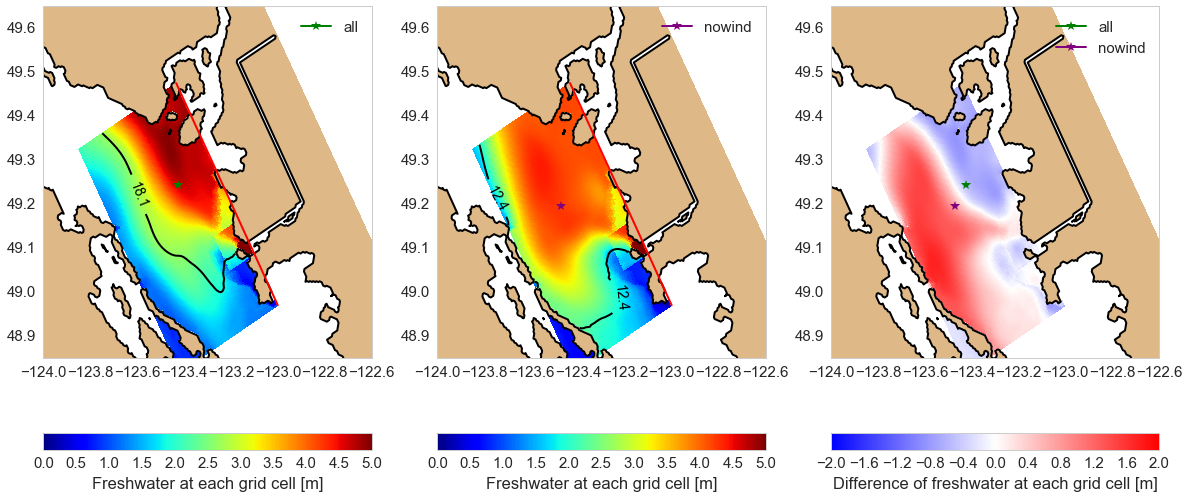

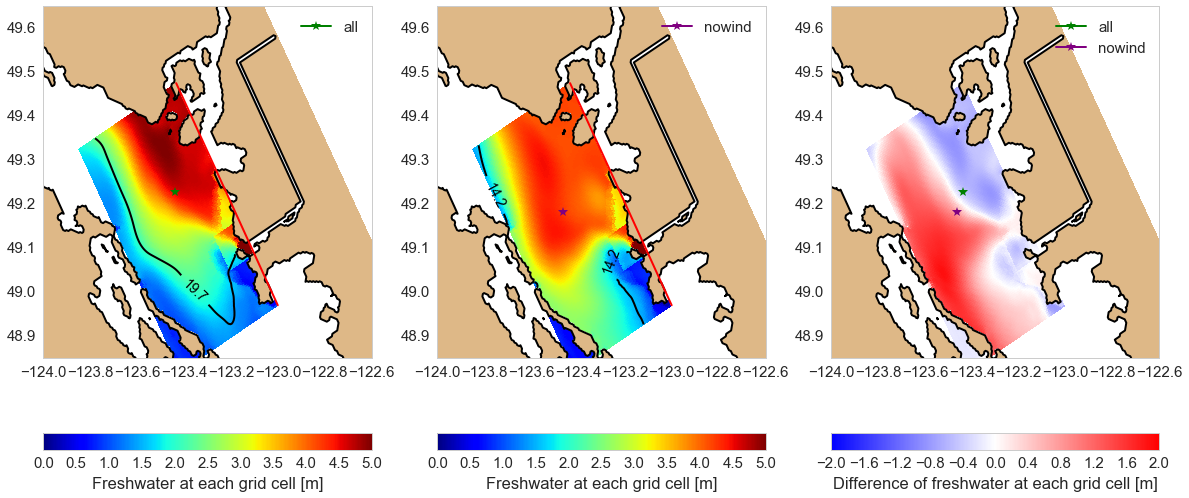

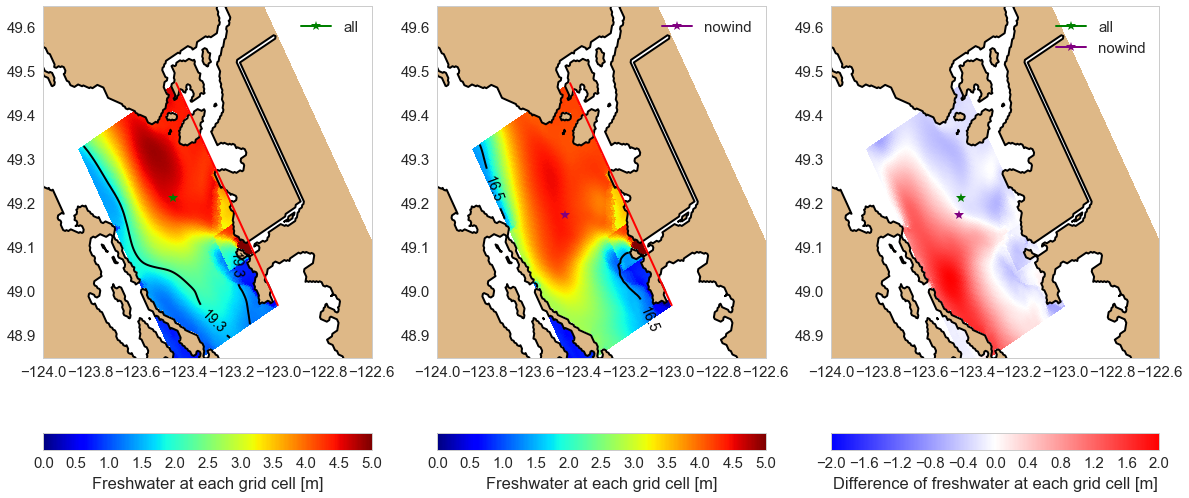

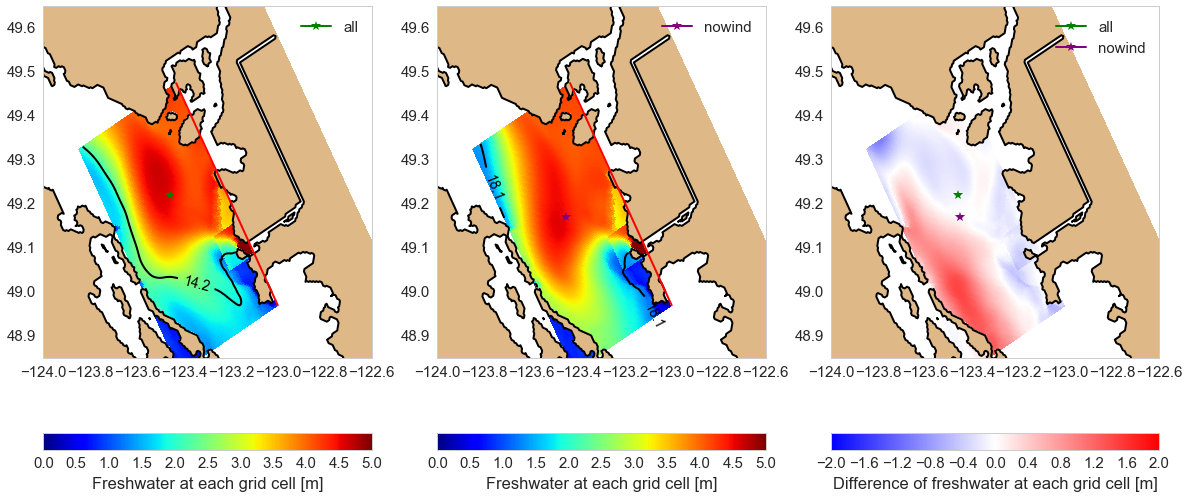

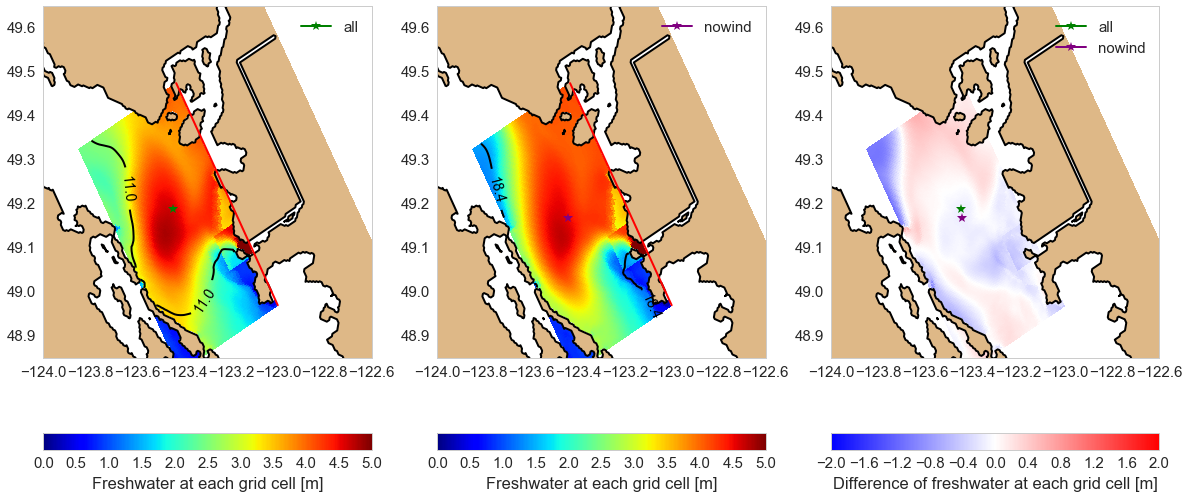

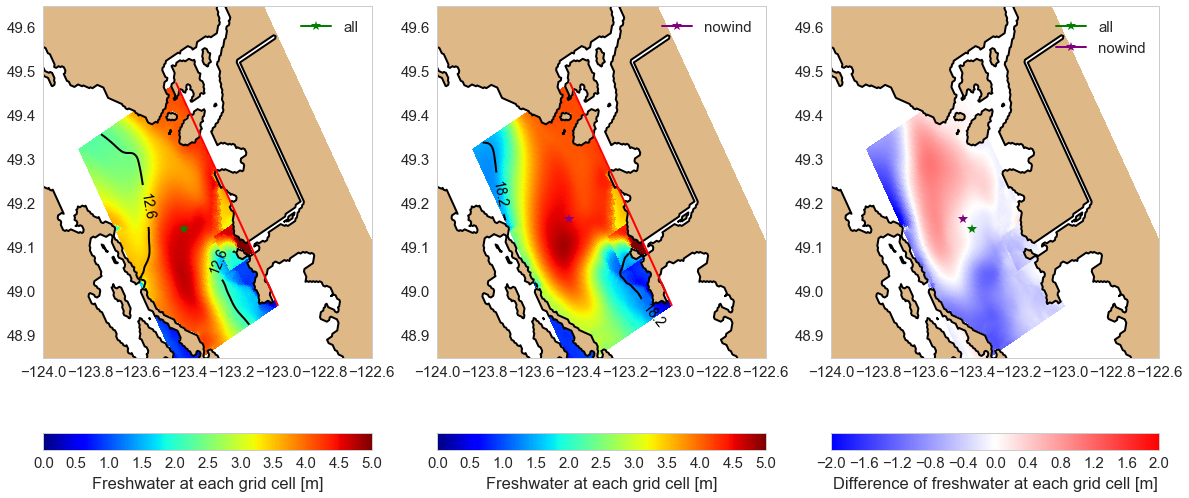

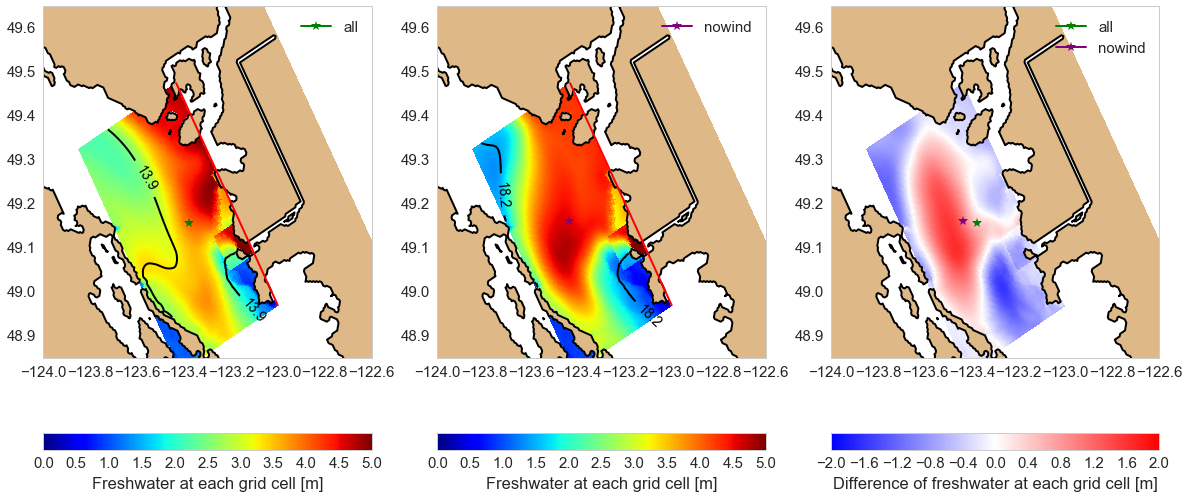

In [16]:
for t in np.arange(0,744,24):
    j,i = plot_plume_position(mayall_T,maynowind_T,t,t+23,10,0,yslices,xslices,['all','nowind'])
    print(j,i)